First, I am building the training, and testing module, integrated gradient and gradCam are at last.

In [703]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from PIL import Image 
from captum.attr import IntegratedGradients
import cv2
import torch.nn.functional as F

In [704]:
base_dir = 'C:/Users/riyam/OneDrive/Desktop/Artificial_Intelligence/Datasets/dogs-vs-cats-subset/subset'
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(base_dir, 'train', 'cats')
train_dogs_dir = os.path.join(base_dir, 'train', 'dogs')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [705]:
# Define transformations
# Define data transformations including augmentation for training data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(150),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(validation_dir, transform=validation_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)

In [706]:
for data_batch, labels_batch in train_loader:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: torch.Size([32, 3, 150, 150])
labels batch shape: torch.Size([32])


In [707]:
# Define data transformations including augmentation for training data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(150),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define transformations for validation data (no augmentation)
validation_transforms = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

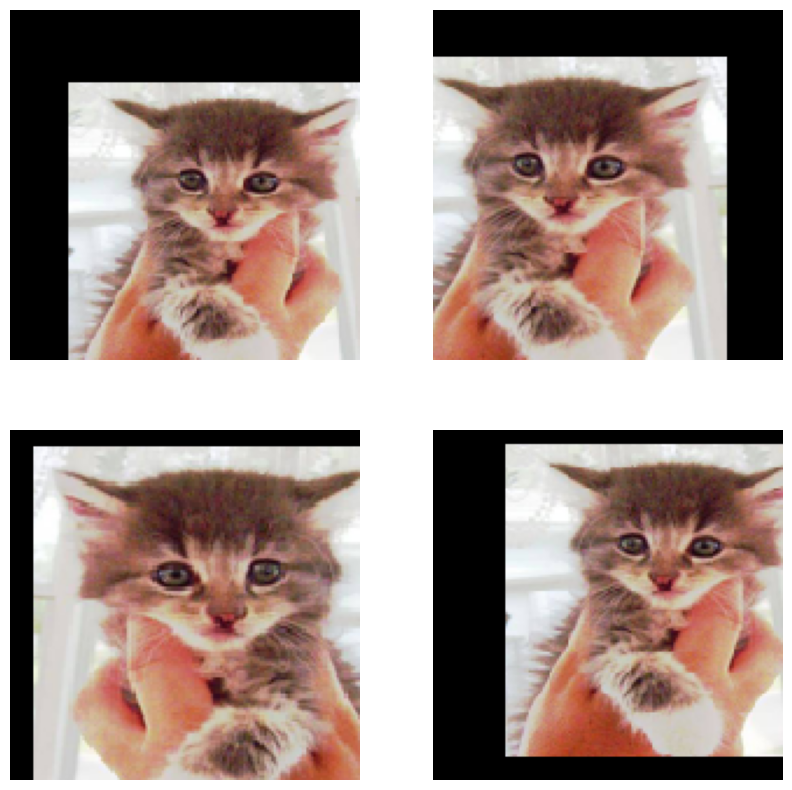

In [708]:
# train_cats_dir is for cats
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# Pick one image to "augment"
img_path = fnames[3]

# Reading the image and resizing it
img = Image.open(img_path).resize((150, 150))

# Convert it to a Tensor
to_tensor = transforms.ToTensor()
x = to_tensor(img).unsqueeze(0)  # Add batch dimension

# Define the transformations
transform = transforms.Compose([
    transforms.RandomRotation(0),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
])

# Generate and display augmented images
plt.figure(figsize=(10, 10))
for i in range(4):
    # Apply transformations
    augmented = transform(x)
    
    # Convert to image for display
    img_display = transforms.ToPILImage()(augmented.squeeze(0))
    
    plt.subplot(2, 2, i+1)
    plt.imshow(img_display)
    plt.axis('off')

plt.show()

#### Building the Model

In [709]:
# Define the CNN model from scratch
class ConvNet(nn.Module):
    def __init__(self):
        # super(ConvNet, self).__init__()
        # self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        # self.dropout = nn.Dropout(0.5)
        # self.fc1 = nn.Linear(128 * 9 * 9, 512) # Adjusted for input size of (150x150)
        # self.fc2 = nn.Linear(512, 1)
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.pool(nn.functional.relu(self.conv1(x)))
        # x = self.pool(nn.functional.relu(self.conv2(x)))
        # x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = self.pool(nn.functional.relu(self.conv4(x)))
        # x = x.view(-1, 128 * 9 * 9) # Flatten the tensor for the fully connected layer
        # x = nn.functional.relu(self.fc1(x))
        # x = self.dropout(x)
        # x = torch.sigmoid(self.fc2(x))
        # return x
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [710]:
# Instantiate the model and move it to GPU if available
model = ConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [711]:
device

device(type='cuda')

In [712]:
# Training loop
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=30):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.round()
            correct_train += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train.double() / len(train_loader.dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = outputs.round()
                correct_val += torch.sum(preds == labels.data)

        val_loss /= len(validation_loader.dataset)
        val_acc = correct_val.double() / len(validation_loader.dataset)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return history

In [713]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

In [714]:
num_epochs=40
history = train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs)

Epoch 1/40, Train Loss: 0.6929, Train Acc: 0.5180, Val Loss: 0.6871, Val Acc: 0.6100
Epoch 2/40, Train Loss: 0.6863, Train Acc: 0.5600, Val Loss: 0.6756, Val Acc: 0.5800
Epoch 3/40, Train Loss: 0.6713, Train Acc: 0.5825, Val Loss: 0.6495, Val Acc: 0.6570
Epoch 4/40, Train Loss: 0.6622, Train Acc: 0.5895, Val Loss: 0.6235, Val Acc: 0.6490
Epoch 5/40, Train Loss: 0.6438, Train Acc: 0.6250, Val Loss: 0.6632, Val Acc: 0.5530
Epoch 6/40, Train Loss: 0.6361, Train Acc: 0.6285, Val Loss: 0.6320, Val Acc: 0.5890
Epoch 7/40, Train Loss: 0.6287, Train Acc: 0.6495, Val Loss: 0.6015, Val Acc: 0.6770
Epoch 8/40, Train Loss: 0.6273, Train Acc: 0.6535, Val Loss: 0.6608, Val Acc: 0.5760
Epoch 9/40, Train Loss: 0.6117, Train Acc: 0.6715, Val Loss: 0.6030, Val Acc: 0.6590
Epoch 10/40, Train Loss: 0.6037, Train Acc: 0.6720, Val Loss: 0.5711, Val Acc: 0.7130
Epoch 11/40, Train Loss: 0.6011, Train Acc: 0.6725, Val Loss: 0.5685, Val Acc: 0.7030
Epoch 12/40, Train Loss: 0.5967, Train Acc: 0.6865, Val Loss: 0

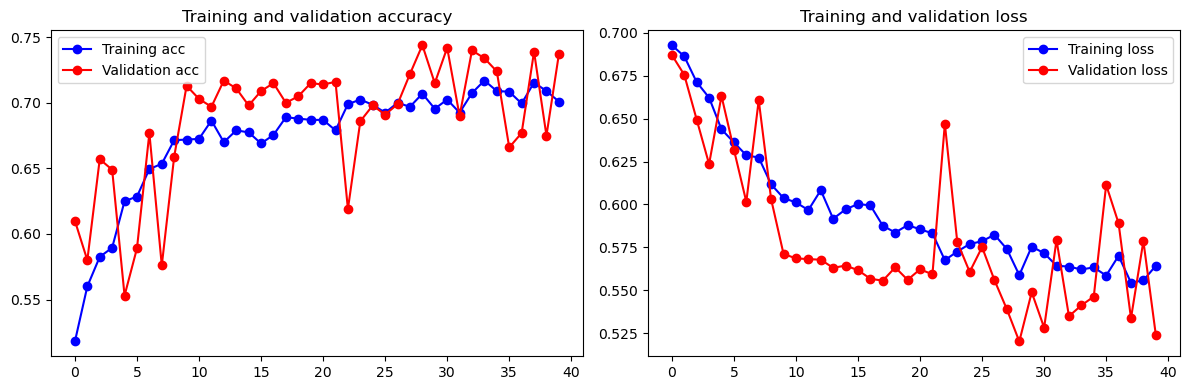

In [715]:
# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], 'bo-', label='Training acc')
plt.plot(history['val_acc'], 'ro-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], 'bo-', label='Training loss')
plt.plot(history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

In [716]:
# Function to plot confusion matrix
def plot_confusion_matrix(model):
    y_true = []
    y_pred_probs = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            y_pred_probs.extend(outputs.flatten())
            y_true.extend(labels.numpy())

    y_pred_probs = np.array(y_pred_probs)
    y_true = np.array(y_true)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true > 0.5,y_pred_probs > 0.5 )
    plt.figure(figsize=(5,5))
    sns.heatmap(cm/np.sum(cm), annot=True ,fmt='.2%')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

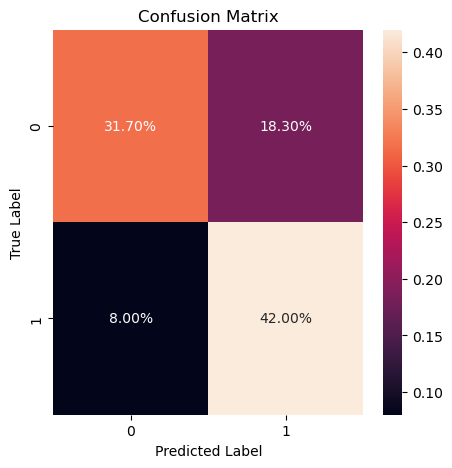

In [717]:
plot_confusion_matrix(model)  

In [718]:
# Save the entire model
torch.save(model, 'cats_and_dogs_small_torch_full.pth')

## Task-1 (Integrated Gradients)

Integrated Gradients is a feature attribution method which explains the prediction of deep neural networks.
It gives the attribution of the prediction of a model based on its input features.

The integrated gradients, calculated the integral of gradients along a staright line between baseline image and input image.

Baseline: A reference input (it is usullay a black image, all pixel values set to 0), represents absence of feature.
Path Integral: The integral along a straight path from baseline to input.
Gradients: Computed at each point along the path.
Interpolation: It is like adding up two images, but taking a fraction of each one.

It follows two axioms: Sensitivity and Invariance
Sensitivity -> If two outputs are different from eachother because there is only one feature that is different in them, 
               then that feature will have non-zero attribution.
Impementation Invariance -> The attributions are always identical for two networks that are functionally equivalent to eachother.               

$IntegratedGrads_i(x)$ is the integrated gradient for the $i$-th feature of input $x$

$x_i$ is the $i$-th feature of the input

$x'_i$ is the $i$-th feature of the baseline input

$F$ is the model function

$\alpha$ is the interpolation parameter

$$IntegratedGrads_i(x) = (x_i - x'_i) \times \int_{\alpha=0}^1 \frac{\partial F(x' + \alpha \times (x - x'))}{\partial x_i} d\alpha$$

In [719]:
# Function to compute gradients
def get_gradients(model, inputs):
    inputs.requires_grad = True
    outputs = model(inputs)
    loss = outputs.sum()
    model.zero_grad()
    loss.backward()
    return inputs.grad

In [720]:
# Interpolation function
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, None, None, None]
    delta = image - baseline
    images = baseline + alphas_x * delta
    return images

In [721]:
# Integrated Gradients function
def integrated_gradients(model, baseline, image, m_steps=50):
    alphas = torch.linspace(0.0, 1.0, steps=m_steps+1).to(image.device)
    interpolated_inputs = interpolate_images(baseline, image, alphas)
    
    grads = []
    for i in range(m_steps+1):
        grad = get_gradients(model, interpolated_inputs[i:i+1])
        grads.append(grad)
    
    grads = torch.cat(grads)
    avg_grads = (grads[:-1] + grads[1:]) / 2.0
    integrated_grads = avg_grads.mean(dim=0) * (image - baseline)
    
    return integrated_grads

In [722]:
# Function to normalize attributions for visualization
def normalize_attributions(attributions):
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())
    return attributions

# Visualization function with normalization
def visualize_attributions(image, attributions):
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title('Original Image')
    plt.axis('off')

    # Attributed Image
    plt.subplot(1, 2, 2)
    corrected_attributions = normalize_attributions(attributions.permute(1, 2, 0)) if attributions.ndim == 3 else normalize_attributions(attributions)
    plt.imshow(corrected_attributions.cpu().numpy(), cmap='viridis')
    plt.title('Integrated Gradients')
    plt.axis('off')
    
    # Create heatmap from attributions
    heatmap = plt.cm.jet(corrected_attributions.cpu().numpy())[:, :, :3]

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


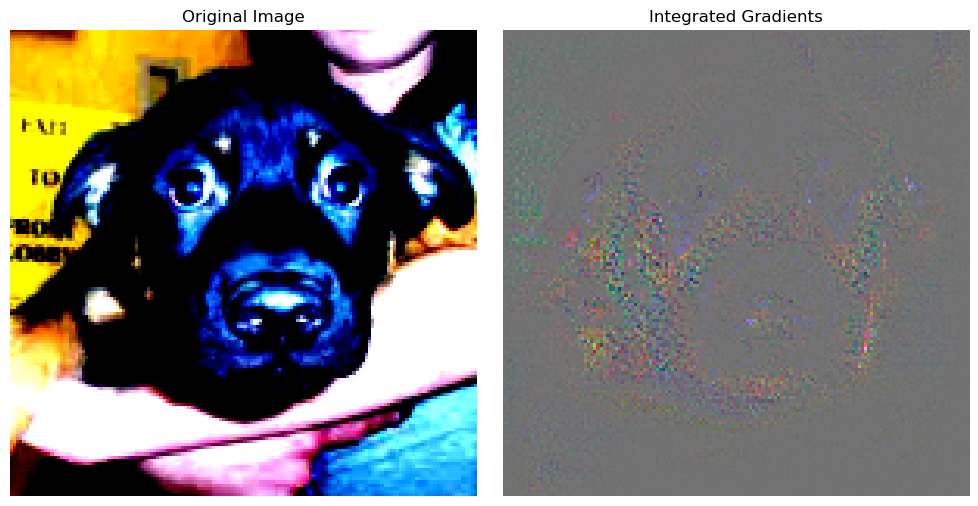

In [723]:
# Load and preprocess an image
image_path = "C:/Users/riyam/OneDrive/Desktop/Artificial_Intelligence/Datasets/dogs-vs-cats-subset/subset/test/dogs/dog.1577.jpg"
image = Image.open(image_path)

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = transform(image).unsqueeze(0).to(device)
baseline = torch.zeros_like(image).to(device)

# Compute integrated gradients
integrated_grads = integrated_gradients(model, baseline, image)

# Visualize the results
visualize_attributions(image.squeeze(), integrated_grads.squeeze())
image = image.to('cpu')
baseline = baseline.to('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


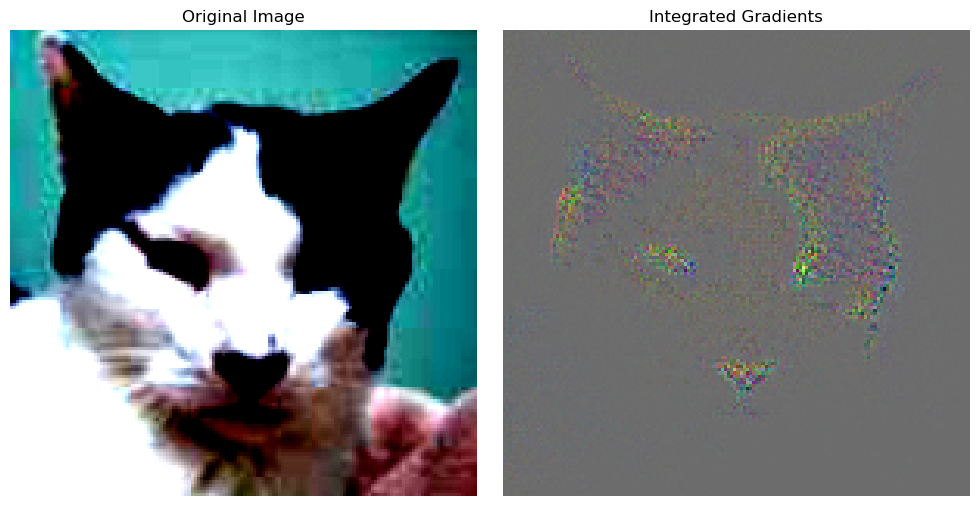

In [724]:
# Load and preprocess an image
image_path = "C:/Users/riyam/OneDrive/Desktop/Artificial_Intelligence/Datasets/dogs-vs-cats-subset/subset/test/cats/cat.1926.jpg"
image = Image.open(image_path)

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = transform(image)
image = image.unsqueeze(0).to(device)
baseline = torch.zeros_like(image)

image = image.to(device)
baseline = baseline.to(device)

# Compute integrated gradients
integrated_grads = integrated_gradients(model, baseline, image)

# Visualize the results
visualize_attributions(image.squeeze(), integrated_grads.squeeze())
image = image.to('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


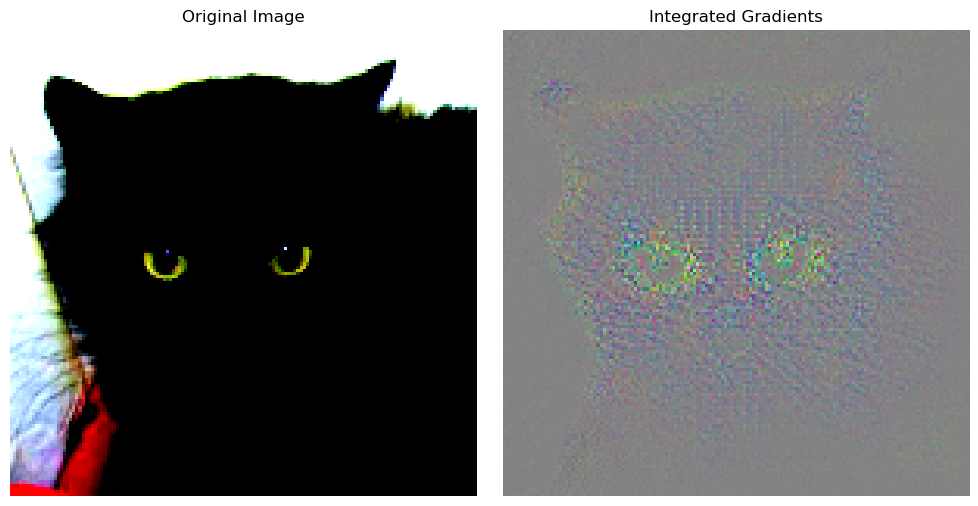

In [725]:
# Load and preprocess an image
image_path = "C:/Users/riyam/OneDrive/Desktop/Artificial_Intelligence/Datasets/dogs-vs-cats-subset/subset/test/cats/cat.1500.jpg"
image = Image.open(image_path)

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = transform(image)
image = image.unsqueeze(0).to(device)
baseline = torch.zeros_like(image)

image = image.to(device)
baseline = baseline.to(device)

# Compute integrated gradients
integrated_grads = integrated_gradients(model, baseline, image)

# Visualize the results
visualize_attributions(image.squeeze(), integrated_grads.squeeze())
image = image.to('cpu')

Results:

It can be seen, the integrated gradients image has highlighted area in cat's and dog's body area, that is, the model is giving more importance to those area. These are the features that are contributing to the model's output.

## Task-2 (GradCam)

In [726]:
# Function to compute gradients
def get_gradients(model, inputs):
    inputs.requires_grad = True
    outputs = model(inputs)
    most_confident_class = get_most_confident_class(outputs)
    loss = F.nll_loss(outputs, most_confident_class)
    model.zero_grad()
    loss.backward()
    return inputs.grad, most_confident_class

In [727]:
# Function to compute Grad-CAM
def compute_gradcam(model, image):
    # Reset activations and gradients
    global activations, gradients
    activations, gradients = [], []
    
    # Forward pass
    outputs = model(image)
    
    # Get the index of the most confident class
    most_confident_class = (outputs > 0.5).float()
    
    # Backward pass
    model.zero_grad()
    loss = F.binary_cross_entropy(outputs, most_confident_class)
    loss.backward()
    
    # Get gradients and activations
    grads = gradients[-1]
    activations = activations[-1].detach()
    
    # Compute weights
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_grads[i]
    
    # Compute Grad-CAM map
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)
    return heatmap

In [728]:
def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

In [729]:
# Visualization function
def visualize_gradcam(original_img_path, grad_cam_map):
    original_img = cv2.imread(original_img_path)
    grad_cam_map_resized = cv2.resize(grad_cam_map.numpy(), (original_img.shape[1], original_img.shape[0]))
    
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map_resized), cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.3 + original_img / 255.0

    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Superimposed Image
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM')
    plt.axis('off')
    
    plt.show()

C:\Users\riyam\anaconda3\lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


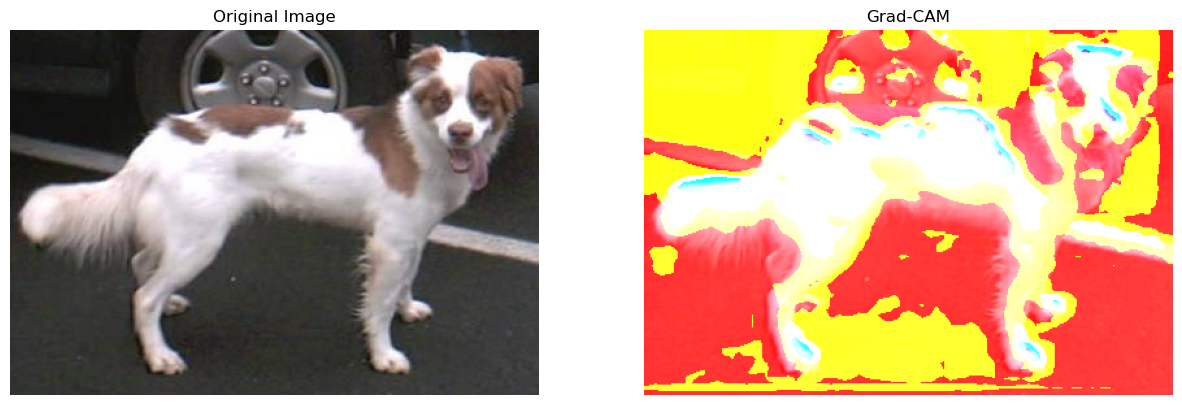

In [730]:
# Choose a specific convolutional layer
model_cpu = model.to('cpu')
target_layer = model_cpu.conv2  # layer to visualize
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Load and preprocess an image
image_path = "C:/Users/riyam/OneDrive/Desktop/Artificial_Intelligence/Datasets/dogs-vs-cats-subset/subset/test/dogs/dog.1500.jpg"
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = transform(image).unsqueeze(0)

# Compute Grad-CAM
grad_cam_map = compute_gradcam(model_cpu, image)

# Visualize Grad-CAM
visualize_gradcam(image_path, grad_cam_map)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


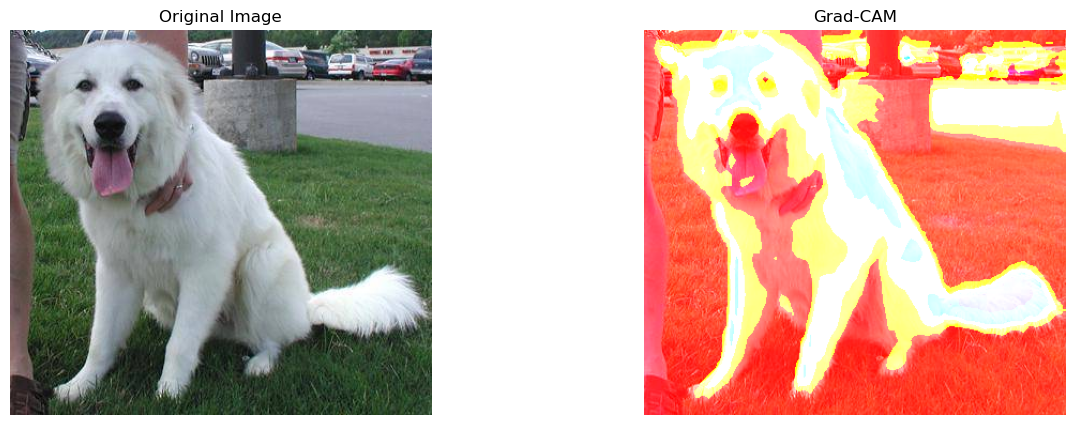

In [731]:
# Choose a specific convolutional layer
model_cpu = model.to('cpu')
target_layer = model_cpu.conv2  # layer to visualize
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Load and preprocess an image
image_path = "C:/Users/riyam/OneDrive/Desktop/Artificial_Intelligence/Datasets/dogs-vs-cats-subset/subset/test/dogs/dog.1504.jpg"
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = transform(image).unsqueeze(0)

# Compute Grad-CAM
grad_cam_map = compute_gradcam(model_cpu, image)

# Visualize Grad-CAM
visualize_gradcam(image_path, grad_cam_map)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


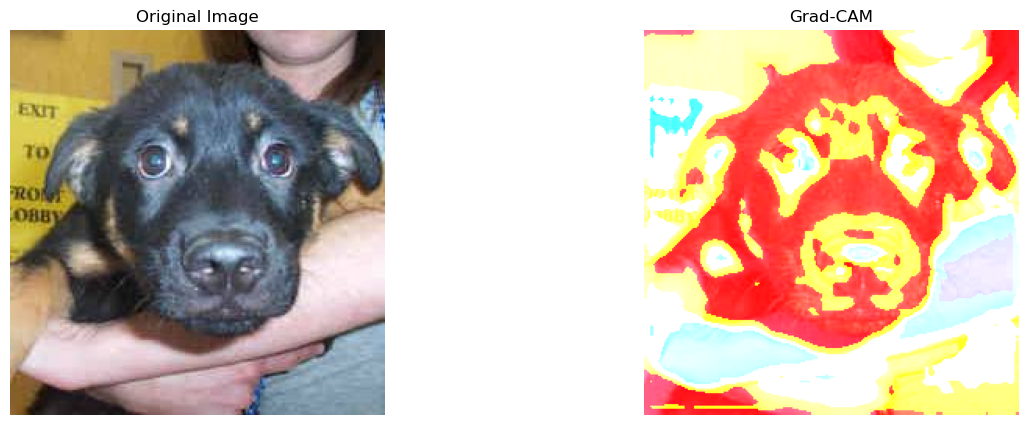

In [747]:
# Choose a specific convolutional layer
model_cpu = model.to('cpu')
target_layer = model_cpu.conv2  # layer to visualize
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Load and preprocess an image
image_path = "C:/Users/riyam/OneDrive/Desktop/Artificial_Intelligence/Datasets/dogs-vs-cats-subset/subset/test/dogs/dog.1577.jpg"
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = transform(image).unsqueeze(0)

# Compute Grad-CAM
grad_cam_map = compute_gradcam(model_cpu, image)

# Visualize Grad-CAM
visualize_gradcam(image_path, grad_cam_map)